In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_score,roc_curve,auc,recall_score,precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/blood cell/data'

CLASSES = [ 'EOSINOPHIL',
            'LYMPHOCYTE',
            "MONOCYTE"
           ]

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

model_acc={}
model_val_acc={}

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=4670, shuffle=True)

Found 4670 images belonging to 3 classes.


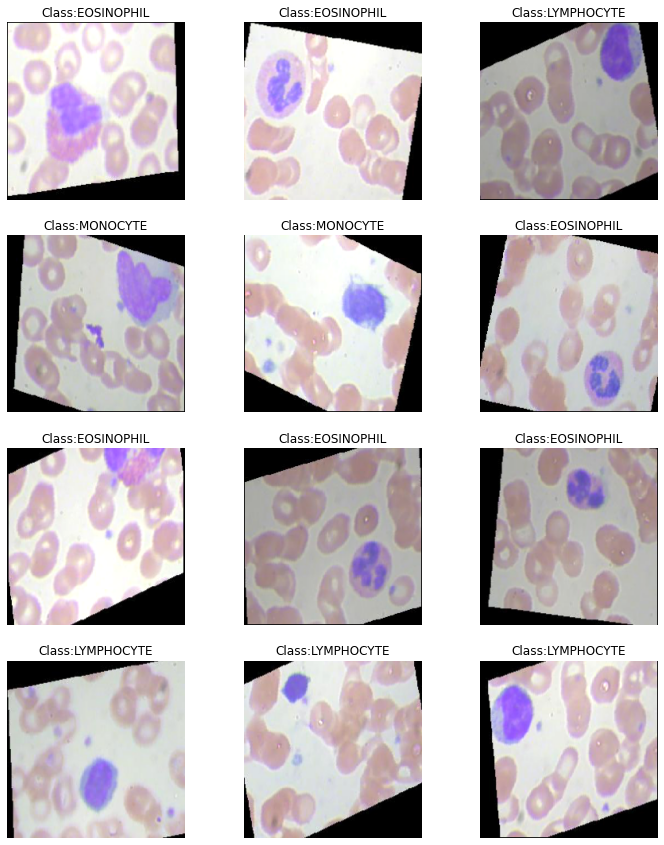

In [ ]:
from random import randint
   
# get image lables
labels =dict(zip([0,1,2], CLASSES))
# get a batch of images
train_data, train_labels = train_data_gen.next()
    
# display a grid of 9 images
plt.figure(figsize=(12, 15))
for i in range(12):
  ax = plt.subplot(4, 3, i + 1)
  idx = randint(0,3000)
  plt.imshow(train_data[idx])
  plt.axis("off")
  plt.title("Class:{}".format(labels[np.argmax(train_labels[idx])]))

In [ ]:
print(train_data.shape, train_labels.shape)

(4670, 224, 224, 3) (4670, 3)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [ ]:
print(train_data.shape)

(3736, 224, 224, 3)


#MobilenetV2

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model_1 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
#Defining other parameters for our CNN model
model_1.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=["acc"])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
EPOCHS = 20
history1 = model_1.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
117/117 [==============================] - 18s 71ms/step - loss: 1.0036 - acc: 0.4893 - val_loss: 0.7083 - val_acc: 0.7173
Epoch 2/20
117/117 [==============================] - 7s 56ms/step - loss: 0.6905 - acc: 0.7050 - val_loss: 0.4421 - val_acc: 0.8383
Epoch 3/20
117/117 [==============================] - 7s 56ms/step - loss: 0.4925 - acc: 0.8003 - val_loss: 0.3250 - val_acc: 0.8790
Epoch 4/20
117/117 [==============================] - 7s 56ms/step - loss: 0.4199 - acc: 0.8346 - val_loss: 0.2991 - val_acc: 0.8801
Epoch 5/20
117/117 [==============================] - 7s 56ms/step - loss: 0.3402 - acc: 0.8672 - val_loss: 0.2704 - val_acc: 0.9015
Epoch 6/20
117/117 [==============================] - 7s 56ms/step - loss: 0.2824 - acc: 0.8972 - val_loss: 0.2186 - val_acc: 0.9186
Epoch 7/20
117/117 [==============================] - 7s 57ms/step - loss: 0.2812 - acc: 0.8948 - val_loss: 0.2017 - val_acc: 0.9325
Epoch 8/20
117/117 [==============================] - 7s 56ms/step -

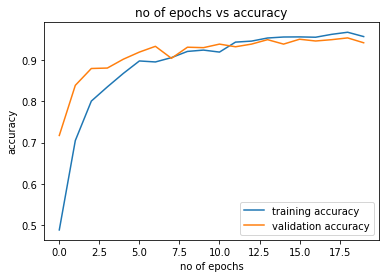

In [ ]:
acc=history1.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history1.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

In [ ]:

Train_acc1=history1.history['acc'][-1]
Val_acc1=history1.history['val_acc'][-1]

model_acc["MobileNet"]=Train_acc1
model_val_acc["MobileNet"]=Val_acc1
print("Train accuracy",Train_acc1)
print("Validation accuracy",Val_acc1)

Train accuracy 0.9561
Validation accuracy 0.9411


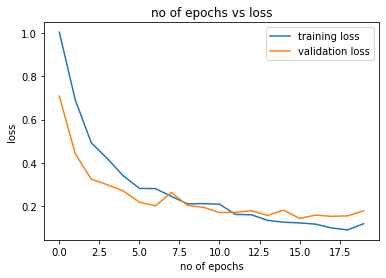

In [ ]:
acc=history1.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history1.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs1 = model_1.predict(test_data, batch_size=32)

[INFO] evaluating network...
30/30 [==============================] - 2s 43ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs1 = np.argmax(predIdxs1, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       298
           1       0.90      0.98      0.94       326
           2       0.96      0.98      0.97       310

    accuracy                           0.94       934
   macro avg       0.95      0.94      0.94       934
weighted avg       0.94      0.94      0.94       934



In [ ]:
cf1=confusion_matrix(test_labels.argmax(axis=1), predIdxs1)
cf1

array([[256,  32,  10],
       [  4, 320,   2],
       [  2,   5, 303]])

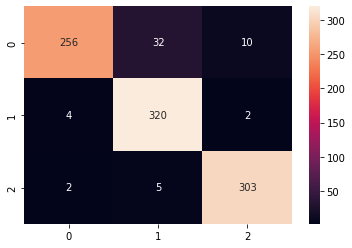

In [ ]:
import seaborn as snsc
sns.heatmap(cf1, annot=True,fmt="1.0f")

# VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
model2 = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

#Adding custom Layers 
x = model2.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation="softmax")(x)

# creating the final model 
model_2 =  Model(inputs=model2.input, outputs=predictions)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model2.layers[:25]:
    layer.trainable = False

In [ ]:
#Defining other parameters for our CNN model
model_2.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=["acc"])

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
EPOCHS = 20
history2 = model_2.fit(train_data, train_labels, validation_data=(test_data, test_labels), batch_size=32, epochs=EPOCHS)

Epoch 1/20
117/117 [==============================] - 33s 253ms/step - loss: 1.8230 - acc: 0.5348 - val_loss: 0.6859 - val_acc: 0.6991
Epoch 2/20
117/117 [==============================] - 24s 206ms/step - loss: 0.6031 - acc: 0.7457 - val_loss: 0.5216 - val_acc: 0.7816
Epoch 3/20
117/117 [==============================] - 24s 202ms/step - loss: 0.4123 - acc: 0.8448 - val_loss: 0.3466 - val_acc: 0.8994
Epoch 4/20
117/117 [==============================] - 24s 202ms/step - loss: 0.3009 - acc: 0.8929 - val_loss: 0.2803 - val_acc: 0.9058
Epoch 5/20
117/117 [==============================] - 24s 203ms/step - loss: 0.2401 - acc: 0.9111 - val_loss: 0.3315 - val_acc: 0.8737
Epoch 6/20
117/117 [==============================] - 24s 203ms/step - loss: 0.1910 - acc: 0.9368 - val_loss: 0.2147 - val_acc: 0.9347
Epoch 7/20
117/117 [==============================] - 24s 202ms/step - loss: 0.1662 - acc: 0.9441 - val_loss: 0.3564 - val_acc: 0.8512
Epoch 8/20
117/117 [==============================] - 2

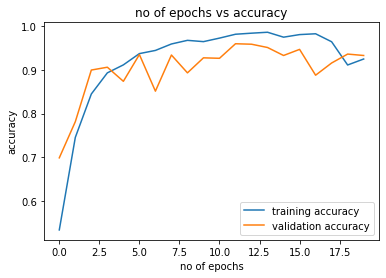

In [ ]:
acc=history2.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history2.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

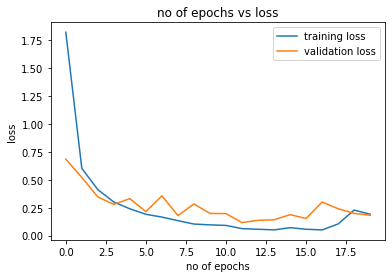

In [ ]:
acc=history2.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history2.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
Train_acc2=history2.history['acc'][-1]
Val_acc2=history2.history['val_acc'][-1]

model_acc["VGG16"]=Train_acc2
model_val_acc["VGG16"]=Val_acc2

print("Train accuracy",Train_acc2)
print("Validation accuracy",Val_acc2)

Train accuracy 0.9245182275772095
Validation accuracy 0.9325481653213501


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs2 = model_2.predict(test_data, batch_size=32)

[INFO] evaluating network...
30/30 [==============================] - 4s 150ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs2 = np.argmax(predIdxs2, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs2))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       298
           1       0.95      0.97      0.96       326
           2       0.97      0.90      0.93       310

    accuracy                           0.93       934
   macro avg       0.93      0.93      0.93       934
weighted avg       0.93      0.93      0.93       934



In [ ]:
cf2=confusion_matrix(test_labels.argmax(axis=1), predIdxs2)
cf2

array([[276,  13,   9],
       [ 10, 316,   0],
       [ 26,   5, 279]])

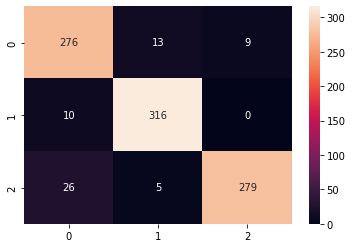

In [ ]:
import seaborn as sns
sns.heatmap(cf2, annot=True,fmt="1.0f")

# InceptionV3

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3

In [ ]:
model3 =InceptionV3(weights='imagenet',include_top=False ,input_shape=(224,224,3)
    )
model3.trainable = False
model3.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
model_3 = Sequential([ 
        model3,   
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22,328,099
Trainable params: 525,315
Non-trainable params: 21,802,784
______________________________________

In [ ]:
#Defining other parameters for our CNN model
model_3.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=["acc"])

In [ ]:
EPOCHS = 20
history3 = model_3.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/20
117/117 [==============================] - 26s 122ms/step - loss: 1.1210 - acc: 0.4687 - val_loss: 0.8868 - val_acc: 0.5942
Epoch 2/20
117/117 [==============================] - 12s 100ms/step - loss: 0.8349 - acc: 0.6009 - val_loss: 0.8096 - val_acc: 0.6221
Epoch 3/20
117/117 [==============================] - 11s 98ms/step - loss: 0.7538 - acc: 0.6499 - val_loss: 0.7370 - val_acc: 0.6670
Epoch 4/20
117/117 [==============================] - 11s 97ms/step - loss: 0.6776 - acc: 0.7007 - val_loss: 0.8239 - val_acc: 0.6028
Epoch 5/20
117/117 [==============================] - 11s 96ms/step - loss: 0.6643 - acc: 0.7080 - val_loss: 0.6903 - val_acc: 0.7013
Epoch 6/20
117/117 [==============================] - 12s 99ms/step - loss: 0.6155 - acc: 0.7216 - val_loss: 0.6658 - val_acc: 0.7034
Epoch 7/20
117/117 [==============================] - 11s 95ms/step - loss: 0.5857 - acc: 0.7422 - val_loss: 0.6302 - val_acc: 0.7313
Epoch 8/20
117/117 [==============================] - 11s 95

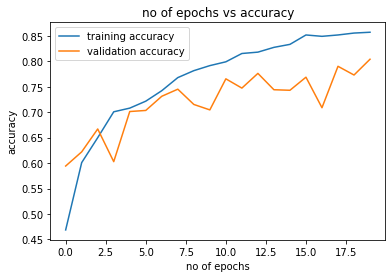

In [ ]:
acc=history3.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history3.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

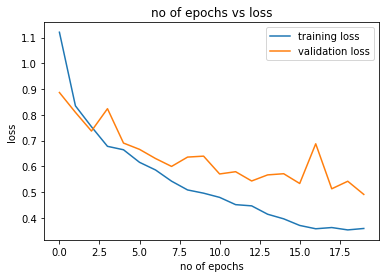

In [ ]:
acc=history3.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)    
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history3.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

In [ ]:
Train_acc3=history3.history['acc'][-1]
Val_acc3=history3.history['val_acc'][-1]

model_acc["Inception"]=Train_acc3
model_val_acc["Inception"]=Val_acc3
print("Train accuracy",Train_acc3)
print("Validation accuracy",Val_acc3)

Train accuracy 0.8570663928985596
Validation accuracy 0.8040685057640076


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs3 = model_3.predict(test_data, batch_size=32)

[INFO] evaluating network...
30/30 [==============================] - 3s 73ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs3 = np.argmax(predIdxs3, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs3))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       291
           1       0.77      0.84      0.81       327
           2       0.86      0.87      0.86       316

    accuracy                           0.80       934
   macro avg       0.80      0.80      0.80       934
weighted avg       0.80      0.80      0.80       934



In [ ]:
cf3=confusion_matrix(test_labels.argmax(axis=1), predIdxs3)
cf3

array([[201,  60,  30],
       [ 35, 276,  16],
       [ 21,  21, 274]])

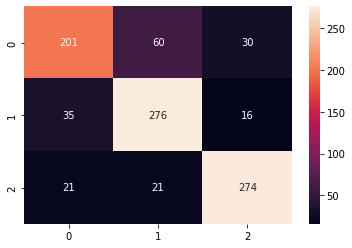

In [ ]:
import seaborn as snsc
sns.heatmap(cf3, annot=True,fmt="1.0f")

# Model Evaluations

# Model training accuracy

In [ ]:
model_scores = pd.DataFrame(model_acc, index=['Score']).transpose()
model_scores = model_scores.sort_values('Score',ascending=False)

In [ ]:
model_scores

,Score
MobileNet,0.956100
VGG16,0.924518
Inception,0.857066


In [ ]:
model_scores = model_scores.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores.style.bar()

,Algorithms,Score
0,MobileNet,0.956100
1,VGG16,0.924518
2,Inception,0.857066


Text(0, 0.5, 'Score')

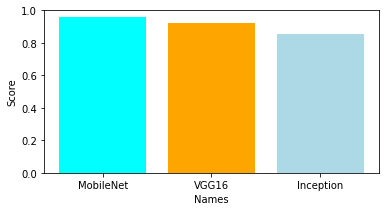

In [ ]:
namess = list(model_acc.keys())
valuess = list(model_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(6,3))
plt.bar(namess,valuess,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")

#  Model Test accuracy

In [ ]:
model_scoress = pd.DataFrame(model_val_acc, index=['Score']).transpose()
model_scores_val = model_scoress.sort_values('Score',ascending=False)

In [ ]:
model_scores_val

,Score
MobileNet,0.941100
VGG16,0.932548
Inception,0.804069


In [ ]:
model_scores_val = model_scores_val.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores_val.style.bar()

,Algorithms,Score
0,MobileNet,0.941100
1,VGG16,0.932548
2,Inception,0.804069


Text(0, 0.5, 'Score')

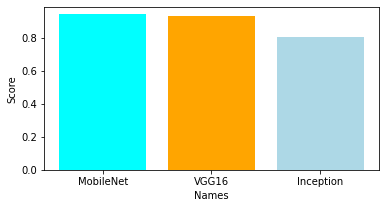

In [ ]:
names = list(model_val_acc.keys())
values = list(model_val_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(6,3))
plt.bar(names,values,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")


# predictions with MobileNet

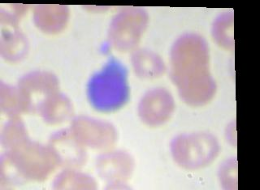

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
imgg = cv2.imread("/content/drive/MyDrive/Colab Notebooks/blood cell/data/LYMPHOCYTE/_10_3699.jpeg") # LYMPHOCYTE
imgg=cv2.resize(imgg, (260, 190))
cv2_imshow(imgg)


In [ ]:
from tensorflow.keras.preprocessing import image
# using the CNN model for predictions
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/blood cell/data/LYMPHOCYTE/_10_3699.jpeg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = model_1.predict(preprocessed_img).flatten()


1/1 [==============================] - 0s 21ms/step


In [ ]:
# generate the predictions
result1 = np.argmax(result)
if result1==0:
  print("img is : LYMPHOCYTE")
elif result1==1:
  print("img is : EOSINOPHIL")
else:
  print("img is :  MONOCYTE")


img is : LYMPHOCYTE
